Theory:
--

Timeseries clustering is very complex, to reduce the complexity we extract metadata from the invervals and cluster them with the more traditional data point clustering methods

Imports
--

In [1]:
!git clone https://github.com/philippwulff/behaviour_mining.git

Cloning into 'behaviour_mining'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 777 (delta 17), reused 58 (delta 5), pack-reused 696
Receiving objects: 100% (777/777), 543.05 MiB | 28.84 MiB/s, done.
Resolving deltas: 100% (212/212), done.
Checking out files: 100% (372/372), done.


In [2]:
import os

import numpy as np
import pandas as pd

from scipy.signal import find_peaks

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Get data

In [3]:
def read_all(folder, nrows=None):
    """
    Read all .csv files from a directory and return the pandas Dataframes.
    """
    dfs = {}

    for root,dirs,files in os.walk(folder):
        for file in files:
            if file.endswith('.csv'):
                path = os.path.join(root, str(file))
                print('Creating DataFrame from {}'.format(path))
                df = pd.read_csv(path, nrows=nrows)
                dfs[path] = df

    return dfs

In [ ]:
dfs

{'behaviour_mining/data/BipedalWalker-v3/a2c/a2c_BipedalWalker-v3.csv':        done   rewards  cumulative_reward  ...  action_1  action_2  action_3
 0       0.0 -0.183477           0.000000  ... -1.000000 -0.453672       1.0
 1       0.0 -0.149685          -0.183477  ...  1.000000  1.000000       1.0
 2       0.0 -0.140859          -0.333162  ...  1.000000  1.000000       1.0
 3       0.0 -0.148345          -0.474020  ...  1.000000  1.000000       1.0
 4       0.0 -0.151209          -0.622366  ... -0.324583  0.992248       1.0
 ...     ...       ...                ...  ...       ...       ...       ...
 99995   0.0  0.000000           0.000000  ...  0.000000  0.000000       0.0
 99996   0.0  0.000000           0.000000  ...  0.000000  0.000000       0.0
 99997   0.0  0.000000           0.000000  ...  0.000000  0.000000       0.0
 99998   0.0  0.000000           0.000000  ...  0.000000  0.000000       0.0
 99999   0.0  0.000000           0.000000  ...  0.000000  0.000000       0.0
 
 [1

In [4]:
dfs = read_all("behaviour_mining/data/BipedalWalker-v3")
#for key in dfs:
  #dfs[key] = dfs[key].drop(columns=["done", "rewards", "cumulative_reward"])

Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/sac/sac_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/td3/td3_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/trpo/trpo_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/ddpg/ddpg_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/a2c/a2c_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/ppo2/ppo2_BipedalWalker-v3.csv
Creating DataFrame from behaviour_mining/data/BipedalWalker-v3/acktr/acktr_BipedalWalker-v3.csv


# Creating the meta data from trajectories

Using these meta data features:

```
    columns = ['mean', 'std', 'median', 'quant_25', 'quant_75', 'loc_max_mean', 
               'loc_max_num', 'loc_min_mean', 'loc_min_num', 'freq_iv', 'strongest_freq']
```



```
# Als Code formatiert
```

Helper functions
--

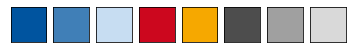

In [5]:
# define color_map
color_map = np.array([[0, 84, 159],       # dark blue
                      [64, 127, 183],     # dark medium blue
                      [199, 221, 242],    # light blue
                      [204, 7, 30],       # red
                      [246, 168, 0],      # yellow
                      [77, 77, 77],       # dark grey
                      [160, 160, 160],    # light medium grey
                      [217, 217, 217]])   # light grey
color_map = color_map / 255

ax = plt.figure().subplots(nrows=1, ncols=color_map.shape[0])
for num, c in enumerate(color_map):
    ax[num].imshow([[c]])
    ax[num].get_xaxis().set_ticks([])
    ax[num].get_yaxis().set_ticks([])
plt.show()

# define text style and size

# size for the text
params = {'font.size' : 15,
          'font.family' : 'arial'
          }
plt.rcParams.update(params)

In [12]:
def split_ser(ser, n=100):
    num_splits = int(10000/n)
    splits = []
    for i in range(num_splits):
        splits.append(ser[i*n:(i+1)*n])

    return splits


def ser_to_meta(x, obs_name=None):
    mean = np.mean(x)
    std = np.std(x)
    median = np.median(sorted(x))
    quant_25 = np.quantile(sorted(x), 0.25)
    quant_75 = np.quantile(sorted(x), 0.75)

    # find all local maxima with a min distance of 10 between them
    loc_max, _ = find_peaks(x, distance=10)
    loc_max_mean = np.mean(x[loc_max])
    loc_max_num = len(loc_max)
    # find all local minima with a min distance of 10 between them
    loc_min, _ = find_peaks(x*-1, distance=10)
    loc_min_mean = np.mean(x[loc_min])
    loc_min_num = len(loc_min)

    # find n_bins strongest present frequencies with fast fourier transform
    n_bins = 5
    fft = np.fft.fft(x)
    T = 1 # sampling interval
    N = len(x)
    f = np.linspace(0, 1 / T, N)
    inds = np.argsort(np.abs(fft)[:N // 2])[-n_bins:] # get indexes of strongest freqs
    inds = inds[np.where(inds!=0)] # ignore the bin at f=0 (if this was a max) because this is the mean
    n_freq = f[inds]

    freq_iv = pd.Interval(min(n_freq), max(n_freq), closed='both')
    strongest_freq = f[inds[-1]] # np.argsort places hightest at the end

    sample = [mean,
              std,
              median,
              quant_25,
              quant_75,
              loc_max_mean,
              loc_max_num,
              loc_min_mean,
              loc_min_num,
              freq_iv,
              strongest_freq]
    columns = ['mean', 'std', 'median', 'quant_25', 'quant_75', 'loc_max_mean', 
               'loc_max_num', 'loc_min_mean', 'loc_min_num', 'freq_iv', 'strongest_freq']

    if obs_name:
        columns = [name+'_'+obs_name for name in columns]

    return sample, columns


def proc_ser(ser, model_name, obs_name=None, n=100):
    splits = split_ser(ser, n)
    metas = []
    columns = None
    for split in splits:
        meta, columns = ser_to_meta(split, obs_name)
        metas.append(meta)
        if not columns:
            columns = columns
    
    df_1 = pd.DataFrame([model_name]*len(metas), columns=['model'])
    df_2 = pd.DataFrame(metas, columns=columns)
    df = pd.concat([df_1,df_2], axis=1)
    return df
  
def get_data(n_interval_lenght=100):
  obs_names = dfs['behaviour_mining/data/BipedalWalker-v3/ppo2/ppo2_BipedalWalker-v3.csv'].columns.values.tolist()
  model_names = [key.split('/')[-2] for key in dfs.keys()]
  obs_names.remove("done")
  obs_names.remove("cumulative_reward")
  df_all = pd.DataFrame()

  for model_df, model_name in zip(dfs.values(), model_names):
    model_meta_df = pd.DataFrame()
    for obs_name in obs_names:
      series = model_df[obs_name].values
      meta_df = proc_ser(series, model_name, obs_name=obs_name, n=n_interval_lenght)
      if (obs_name!="rewards"):
        meta_df = meta_df.drop(columns="model")
      model_meta_df = pd.concat([model_meta_df, meta_df], axis=1)
    df_all = pd.concat([df_all, model_meta_df], axis=0)
  print("done with importing data")
  print (df_all)
  return df_all

def remove_unstable_columns(df_all, obs_names=None): 
  for obs_name in obs_names:
    #min_freqs, max_freqs = [], []
    #for iv in df_all['freq_iv']:
      #min_freqs.append(iv.left)
      #max_freqs.append(iv.right)
    #df_all['min_freq'+'_'+obs_name] = min_freqs
    #df_all['max_freq'+'_'+obs_name] = max_freqs
    df_all = df_all.drop('loc_max_mean'+'_'+obs_name, axis=1)
    df_all = df_all.drop('freq_iv'+'_'+obs_name, axis=1)
    df_all = df_all.drop('loc_min_mean'+'_'+obs_name, axis=1)
  df_all
  return df_all

def cluster(df_all, n_clusters=7):
  df_without_model = df_all.drop(columns="model")
  n_clusters=n_clusters
  km = KMeans(n_clusters=n_clusters)
  km.fit(df_without_model)
  prediction = km.predict(df_without_model)
  occurance_dict={}
  model_names = [key.split('/')[-2] for key in dfs.keys()]
  for i in range(n_clusters):
    temp_dict={}
    for name in model_names:
      temp_dict[name]=0
    occurance_dict[i] = temp_dict
  for i in range(len(prediction)):
    occurance_dict[prediction[i]][df_all.iloc[i,0]] = occurance_dict[prediction[i]][df_all.iloc[i,0]]+1
  print("number of intervals that an algorithms occurs in the clusters")
  for i in range(n_clusters):
    print("cluster "+str(i)+": "+str(occurance_dict[i]))
  print(df_without_model)
  print(prediction)
  return km, prediction

def get_data_and_cluster(n_clusters=7, n_interval_lenght=100, n_intervals=100, k=2):
  df_all = get_data(n_interval_lenght=n_interval_lenght)
  obs_names = dfs['behaviour_mining/data/BipedalWalker-v3/ppo2/ppo2_BipedalWalker-v3.csv'].columns.values.tolist()
  obs_names.remove("done")
  obs_names.remove("cumulative_reward")
  print(df_all)
  print(df_all.size)
  df_all = remove_unstable_columns(df_all, obs_names)
  km, prediction = cluster(df_all, n_clusters=n_clusters)
  time_array = create_time_array(n_interval_lenght)
  #count_occurances(prediction, n_intervals=n_intervals)
  print(df_all)
  plot(df_all, dfs, km, prediction, time_array, n_clusters=n_clusters, n_intervals=n_intervals, interval_lenght=n_interval_lenght, k=k)

def count_occurances(prediction, n_intervals=100):
  file = open("timesteps_"+str(data.shape[1])+"_cluster_ "+str(n_clusters)+".txt", "w")
  file.write("Each Row is a Cluster and each column is a algorithm")
  file.write("0:ppo2, 1:acktr, 2:a2c, 3:ddpg, 4:sac, 5:trpo, 6:td3")
  occurence_dict={}
  for i in range(7):
    occurence_dict[i]=[]
  for j in range(prediction):
    algo = 0
    for m in range (7):
      if j<=(n_intervals*(m+1)):
        algo = m
        break
    occurence_dict[algo][prediction[j]] =  occurence_dict[algo][prediction[j]]+1
  print(occurence_dict)
  #for cluster in occurences:
  #  file.write(str(cluster))
  file.close()

def create_time_array(interval_lenght):
  time_array=[]
  for i in range(interval_lenght):
    time_array.append(i)
  print("created time array")
  return time_array

def get_timeseries(data, slicenumber, interval_lenght=100, n_intervals=100):
  return dfs.get(data[slicenumber, 1])[slicenumber*interval_lenght:(slicenumber+1)*interval_lenght]

def plot(data, dfs, km, prediction, time_array, n_intervals=100, interval_lenght=100, n_clusters=6, k=10):
  columns = dfs['behaviour_mining/data/BipedalWalker-v3/ppo2/ppo2_BipedalWalker-v3.csv'].columns.values.tolist()
  n_columns = data.shape[1]
  fig, axs = plt.subplots(3, n_clusters)
  fig.set_size_inches(30, 70)
  fig.patch.set_facecolor('xkcd:white')
  ###new style
  a4_breite_cm = 21
  seitenraender = 2.5 + 2.5
  grafik_scale = 1
  width = (a4_breite_cm-seitenraender) * 0.393701
  #ergibt irgendwie nicht die richtige breite daher hier erfahrungswert hartgecoded
  width=11.69 *2
  height = 7.5 * 0.393701
  fig.set_size_inches(width, 8)
  ###
  l0, l1, l2, l3, l4, l5, l6=0, 0, 0, 0, 0, 0, 0
  for j in range(prediction.size): #iterate through the number of clustered objects
    for i in range (n_columns-1): #iterate through the number of columns
      if (i==7 or (i==8 or i==9)):      #get what algo this is from
        algo = 0
        for m in range (7):
          if j<=(n_intervals*(m+1)):
            algo = m
            break
        algodataframe = dfs[dfs_keys[algo]]        #get the dataframe of the algo
        intervalnumber = j-(algo*n_intervals) #get which interval of this algorithm it is
        cluster = prediction[j]               #get what cluster it is
        timeseries = algodataframe[intervalnumber*interval_lenght: (intervalnumber +1) *interval_lenght] #get the actual timeseries data
        axs[i-7, cluster].set_ylim([-1.5, 1.5])
        if algo==0:
          if (l0%k)!=0:
            l0=l0+1
            continue
          l0=l0+1
          axs[i-7, cluster].plot(time_array, timeseries.iloc[:, i], c=color_map[0], label ='Cluster'+str(cluster))
        elif algo==1:
          if (l1%k)!=0:
            l1=l1+1
            continue
          l1=l1+1
          axs[i-7, cluster].plot(time_array, timeseries.iloc[:, i], c=color_map[1], label ='Cluster'+str(cluster))
        elif algo==2:
          if (l2%k)!=0:
            l2=l2+1
            continue
          l2=l2+1
          axs[i-7, cluster].plot(time_array, timeseries.iloc[:, i], c=color_map[2], label ='Cluster'+str(cluster))
        elif algo==3:
          if (l3%k)!=0:
            l3=l3+1
            continue
          l3=l3+1
          axs[i-7, cluster].plot(time_array, timeseries.iloc[:, i], c=color_map[4], label ='Cluster'+str(cluster))
        elif algo==4:
          if (l4%k)!=0:
            l4=l4+1
            continue
          l4=l4+1
          axs[i-7, cluster].plot(time_array, timeseries.iloc[:, i], c=color_map[5], label ='Cluster'+str(cluster))
        elif algo==5:
          if (l5%k)!=0:
            l5=l5+1
            continue
          l5=l5+1
          axs[i-7, cluster].plot(time_array, timeseries.iloc[:, i], c=color_map[6], label ='Cluster'+str(cluster))
        elif algo==6:
          if (l6%k)!=0:
            l6=l6+1
            continue
          l6=l6+1
          print(time_array)
          print(timeseries.iloc[:, i])
          axs[i-7, cluster].plot(time_array, timeseries.iloc[:, i], c=color_map[7], label ='Cluster'+str(cluster))
        else:
          print("error unknown algorithm")
        #Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.
        #axs[i-4, j].plot(time_array, km.cluster_centers_[j , : , i].ravel(), c=color_map[3], linewidth=3, label = 'Centroids')
        axs[i-7, cluster].set_title(columns[i]+", cluster "+str(cluster))
        axs[i-7, cluster].set_xlabel("Time steps")
        axs[i-7, cluster].set_ylabel("Value")
  fig.tight_layout()
  plt.savefig("timesteps_"+str(data.shape[1])+"_cluster_"+ str(n_clusters)+".svg",
            format="svg",
            dpi=1000, # recommendation for publication plots
            bbox_inches='tight', # Plot will be occupy a maximum of available space
            )
  #if k!=100000:
    #fig.savefig("timesteps_"+str(data.shape[1])+"_cluster_ "+str(n_clusters)+"_linesPP_"+str(k)+'.png', dpi=100)
  #else:
    #fig.savefig("timesteps_"+str(data.shape[1])+"_cluster_ "+str(n_clusters)+"_allLines.png", dpi=100)
  fig.show()


def create_slices(data_dict, n_intervals=1000, interval_lenght=100):
  slice_dict = {} #dictionary with all sliced dataset dictionarys
  slice_array = []
  for algo in data_dict:
    temp_dict={}#sliced dictionary for current algo
    temp_array=[]
    for i in range(n_intervals):
      temp_slice =data_dict[algo].iloc[(i*interval_lenght):((i+1)*interval_lenght)] # one slice of 100 steps
      temp_dict[i]=temp_slice
      temp_array.append(temp_slice)
    slice_dict[algo]=temp_dict
    slice_array.append(temp_array)
  print("data contains these algorithms")
  print(slice_dict.keys())
  print("with this many intervals each")
  #print(slice_dict["ppo2"].keys())
  print("with such a time series")
  #print(slice_dict["ppo2"][0])
  return slice_dict

list of dictionary keys in correct order

In [7]:
dfs_keys = ["behaviour_mining/data/BipedalWalker-v3/ppo2/ppo2_BipedalWalker-v3.csv", "behaviour_mining/data/BipedalWalker-v3/acktr/acktr_BipedalWalker-v3.csv", "behaviour_mining/data/BipedalWalker-v3/a2c/a2c_BipedalWalker-v3.csv", "behaviour_mining/data/BipedalWalker-v3/ddpg/ddpg_BipedalWalker-v3.csv", "behaviour_mining/data/BipedalWalker-v3/sac/sac_BipedalWalker-v3.csv", "behaviour_mining/data/BipedalWalker-v3/trpo/trpo_BipedalWalker-v3.csv", "behaviour_mining/data/BipedalWalker-v3/td3/td3_BipedalWalker-v3.csv"]

Concatenate meta data from all models for one observation to a single DataFrame
--

If the trajectory of a model stays constantly 0, the np.mean() function will impute NaN as the mean value. 

#clustering

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/numpy

done with importing data
    model  ...  strongest_freq_action_3
0     sac  ...                 0.060606
1     sac  ...                 0.080808
2     sac  ...                 0.060606
3     sac  ...                 0.080808
4     sac  ...                 0.080808
..    ...  ...                      ...
95  acktr  ...                 0.080808
96  acktr  ...                 0.060606
97  acktr  ...                 0.070707
98  acktr  ...                 0.070707
99  acktr  ...                 0.191919

[700 rows x 320 columns]
    model  ...  strongest_freq_action_3
0     sac  ...                 0.060606
1     sac  ...                 0.080808
2     sac  ...                 0.060606
3     sac  ...                 0.080808
4     sac  ...                 0.080808
..    ...  ...                      ...
95  acktr  ...                 0.080808
96  acktr  ...                 0.060606
97  acktr  ...                 0.070707
98  acktr  ...                 0.070707
99  acktr  ...               

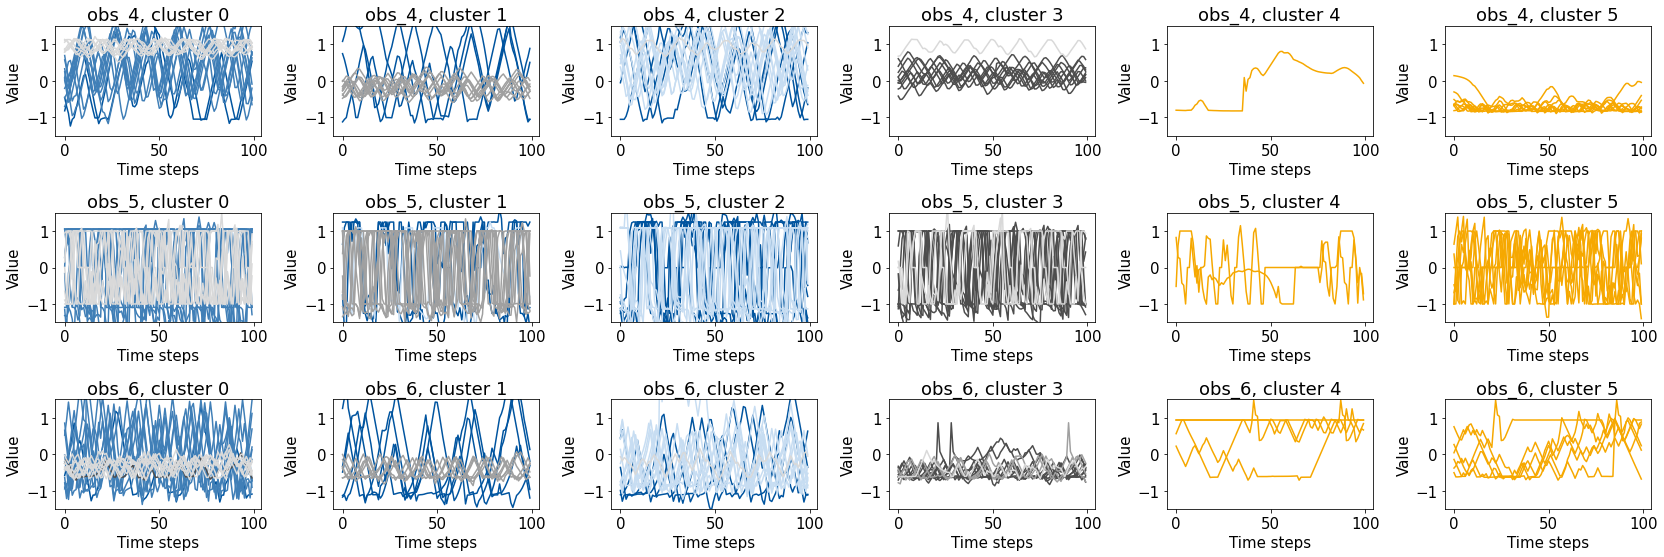

In [13]:
get_data_and_cluster(n_clusters=6, n_interval_lenght=100, k=10)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
..    ...       ...                ...  ...       ...       ...       ...
895   0.0  0.485339          88.018678  ... -0.943921  0.335091 -0.181050
896   0.0  0.634671          88.504017  ... -0.671516 -0.721102  0.992434
897   0.0  0.603979          89.138688  ... -0.997728 -0.911427  0.998545
898   0.0  0.535384          89.742668  ... -0.838278 -0.650813  1.000000
899   0.0  0.504265          90.278052  ...  0.918614 -0.731152  1.000000

[100 rows x 31 columns]
609
j609algo: 6intervalnumber: 9
timeseries
     done   rewards  cumulative_reward  ...  action_1  action_2  action_3
900   0.0  0.512725          90.782317  ...  0.584333 -0.299838  1.000000
901   0.0  0.528171          91.295042  ...  0.330075 -0.070490  1.000000
902   0.0  0.539937          91.823213  ...  0.279090 -0.053411  1.000000
903   0.0  0.666827          92.363150  ... -0.267159  0.069576  1.000000
904   0.0  0.607170          93.029977  ... -0.997

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

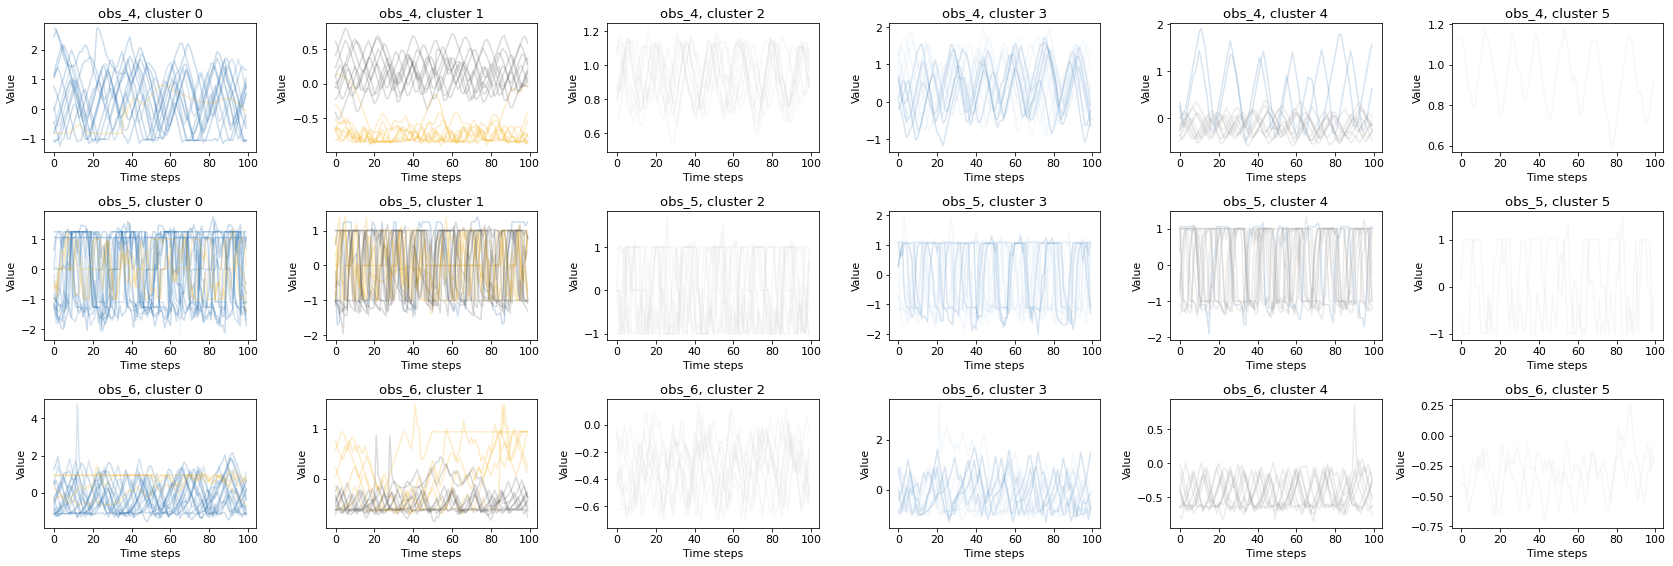

In [ ]:
get_data_and_cluster(n_clusters=6, n_interval_lenght=100, k=10)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy

done with importing data
     model  ...  strongest_freq_action_3
0     ppo2  ...                 0.034483
1     ppo2  ...                 0.068966
2     ppo2  ...                 0.034483
3     ppo2  ...                 0.034483
4     ppo2  ...                 0.034483
..     ...  ...                      ...
328  acktr  ...                 0.034483
329  acktr  ...                 0.172414
330  acktr  ...                 0.206897
331  acktr  ...                 0.206897
332  acktr  ...                 0.068966

[2331 rows x 320 columns]
     model  ...  strongest_freq_action_3
0     ppo2  ...                 0.034483
1     ppo2  ...                 0.068966
2     ppo2  ...                 0.034483
3     ppo2  ...                 0.034483
4     ppo2  ...                 0.034483
..     ...  ...                      ...
328  acktr  ...                 0.034483
329  acktr  ...                 0.172414
330  acktr  ...                 0.206897
331  acktr  ...                 0.206897
332  

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
7020    1.000437e+00
7021    9.584820e-01
7022    5.960464e-08
7023    2.980232e-08
7024    0.000000e+00
7025   -3.727730e-01
7026   -1.000001e+00
7027   -1.000001e+00
7028    9.354552e-02
7029   -7.260420e-01
7030   -6.766253e-01
7031    1.817258e-01
7032    7.969971e-01
7033    1.001866e+00
7034    7.968583e-01
7035    2.625109e-01
7036    1.000000e+00
7037   -3.453571e-01
7038   -1.000000e+00
7039   -8.319014e-01
7040   -1.000002e+00
7041   -1.791029e-01
7042   -5.928380e-01
7043   -1.000272e+00
7044   -9.372514e-02
7045    7.941681e-01
7046    9.999998e-01
7047    6.734546e-01
7048    9.983609e-01
7049    6.855693e-01
Name: obs_5, dtype: float64
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
7110   -0.265048
7111   -0.308243
7112   -0.329869
7113   -0.447281
7114   -0.563566
7115   -0.433454
7116   -0.302678
7

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

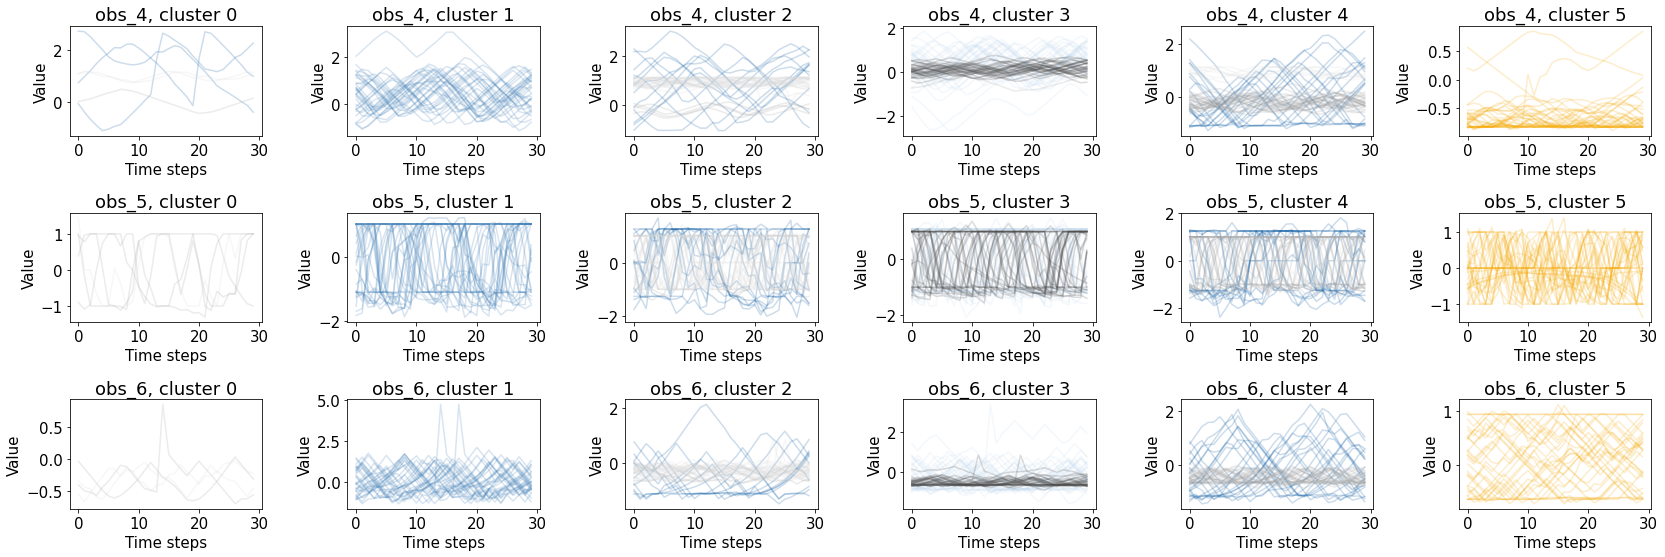

In [ ]:
get_data_and_cluster(n_clusters=6, n_interval_lenght=30, n_intervals=333, k=10)

In [ ]:
get_data_and_cluster(n_clusters=3, n_interval_lenght=100)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy

done with importing data
   model  ...  strongest_freq_action_3
0   ppo2  ...                 0.040404
1   ppo2  ...                 0.040404
2   ppo2  ...                 0.040404
3   ppo2  ...                 0.050505
4   ppo2  ...                 0.040404
..   ...  ...                      ...
5    sac  ...                 0.050505
6    sac  ...                 0.070707
7    sac  ...                 0.070707
8    sac  ...                 0.060606
9    sac  ...                 0.070707

[70 rows x 320 columns]
   model  ...  strongest_freq_action_3
0   ppo2  ...                 0.040404
1   ppo2  ...                 0.040404
2   ppo2  ...                 0.040404
3   ppo2  ...                 0.050505
4   ppo2  ...                 0.040404
..   ...  ...                      ...
5    sac  ...                 0.050505
6    sac  ...                 0.070707
7    sac  ...                 0.070707
8    sac  ...                 0.060606
9    sac  ...                 0.070707

[70 rows x 32

In [ ]:
get_data_and_cluster(n_clusters=3, n_interval_lenght=100)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy

done with importing data
    model  ...  strongest_freq_action_3
0   acktr  ...                 0.070707
1   acktr  ...                 0.060606
2   acktr  ...                 0.090909
3   acktr  ...                 0.212121
4   acktr  ...                 0.060606
..    ...  ...                      ...
95    sac  ...                 0.080808
96    sac  ...                 0.060606
97    sac  ...                 0.070707
98    sac  ...                 0.050505
99    sac  ...                 0.060606

[700 rows x 320 columns]
224000
number of intervals that an algorithms occurs in the clusters
cluster 0: {'acktr': 86, 'td3': 98, 'trpo': 91, 'ddpg': 0, 'ppo2': 1, 'a2c': 50, 'sac': 51}
cluster 1: {'acktr': 14, 'td3': 2, 'trpo': 9, 'ddpg': 1, 'ppo2': 99, 'a2c': 50, 'sac': 49}
cluster 2: {'acktr': 0, 'td3': 0, 'trpo': 0, 'ddpg': 99, 'ppo2': 0, 'a2c': 0, 'sac': 0}


In [ ]:
get_data_and_cluster(n_clusters=3, n_interval_lenght=30)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/numpy

done with importing data
     model  ...  strongest_freq_action_3
0    acktr  ...                 0.034483
1    acktr  ...                 0.068966
2    acktr  ...                 0.068966
3    acktr  ...                 0.068966
4    acktr  ...                 0.068966
..     ...  ...                      ...
328    sac  ...                 0.068966
329    sac  ...                 0.103448
330    sac  ...                 0.068966
331    sac  ...                 0.034483
332    sac  ...                 0.137931

[2331 rows x 320 columns]
745920
number of intervals that an algorithms occurs in the clusters
cluster 0: {'acktr': 252, 'td3': 333, 'trpo': 0, 'ddpg': 0, 'ppo2': 104, 'a2c': 56, 'sac': 0}
cluster 1: {'acktr': 81, 'td3': 0, 'trpo': 0, 'ddpg': 0, 'ppo2': 229, 'a2c': 276, 'sac': 0}
cluster 2: {'acktr': 0, 'td3': 0, 'trpo': 333, 'ddpg': 333, 'ppo2': 0, 'a2c': 1, 'sac': 333}


In [ ]:
get_data_and_cluster(n_clusters=7, n_interval_lenght=15)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



done with importing data
     model  ...  strongest_freq_action_3
0    acktr  ...                 0.070707
1    acktr  ...                 0.060606
2    acktr  ...                 0.090909
3    acktr  ...                 0.212121
4    acktr  ...                 0.060606
..     ...  ...                      ...
995    sac  ...                 0.494949
996    sac  ...                 0.494949
997    sac  ...                 0.494949
998    sac  ...                 0.494949
999    sac  ...                 0.494949

[7000 rows x 320 columns]
number of intervals that an algorithms occurs in the clusters
cluster 0: {'acktr': 933, 'td3': 0, 'trpo': 0, 'ppo2': 45, 'a2c': 742, 'ddpg': 0, 'sac': 5}
cluster 1: {'acktr': 3, 'td3': 988, 'trpo': 12, 'ppo2': 0, 'a2c': 1, 'ddpg': 0, 'sac': 170}
cluster 2: {'acktr': 6, 'td3': 5, 'trpo': 9, 'ppo2': 4, 'a2c': 8, 'ddpg': 5, 'sac': 6}
cluster 3: {'acktr': 55, 'td3': 0, 'trpo': 92, 'ppo2': 944, 'a2c': 230, 'ddpg': 0, 'sac': 409}
cluster 4: {'acktr': 0, 'td3

In [ ]:
get_data_and_cluster(n_clusters=3, n_interval_lenght=100)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



done with importing data
     model  ...  strongest_freq_action_3
0    acktr  ...                 0.070707
1    acktr  ...                 0.060606
2    acktr  ...                 0.090909
3    acktr  ...                 0.212121
4    acktr  ...                 0.060606
..     ...  ...                      ...
995    sac  ...                 0.494949
996    sac  ...                 0.494949
997    sac  ...                 0.494949
998    sac  ...                 0.494949
999    sac  ...                 0.494949

[7000 rows x 320 columns]
number of intervals that an algorithms occurs in the clusters
cluster 0: {'acktr': 155, 'td3': 25, 'trpo': 122, 'ppo2': 989, 'a2c': 564, 'ddpg': 163, 'sac': 511}
cluster 1: {'acktr': 839, 'td3': 970, 'trpo': 869, 'ppo2': 7, 'a2c': 428, 'ddpg': 832, 'sac': 483}
cluster 2: {'acktr': 6, 'td3': 5, 'trpo': 9, 'ppo2': 4, 'a2c': 8, 'ddpg': 5, 'sac': 6}


In [ ]:
get_data_and_cluster(n_clusters=3, n_interval_lenght=30)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



done with importing data
     model  ...  strongest_freq_action_3
0    acktr  ...                 0.070707
1    acktr  ...                 0.060606
2    acktr  ...                 0.090909
3    acktr  ...                 0.212121
4    acktr  ...                 0.060606
..     ...  ...                      ...
995    sac  ...                 0.494949
996    sac  ...                 0.494949
997    sac  ...                 0.494949
998    sac  ...                 0.494949
999    sac  ...                 0.494949

[7000 rows x 320 columns]
number of intervals that an algorithms occurs in the clusters
cluster 0: {'acktr': 6, 'td3': 5, 'trpo': 9, 'ppo2': 4, 'a2c': 8, 'ddpg': 5, 'sac': 6}
cluster 1: {'acktr': 155, 'td3': 25, 'trpo': 122, 'ppo2': 989, 'a2c': 564, 'ddpg': 163, 'sac': 511}
cluster 2: {'acktr': 839, 'td3': 970, 'trpo': 869, 'ppo2': 7, 'a2c': 428, 'ddpg': 832, 'sac': 483}


In [ ]:
get_data_and_cluster(n_clusters=3, n_interval_lenght=15)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



done with importing data
     model  ...  strongest_freq_action_3
0    acktr  ...                 0.070707
1    acktr  ...                 0.060606
2    acktr  ...                 0.090909
3    acktr  ...                 0.212121
4    acktr  ...                 0.060606
..     ...  ...                      ...
995    sac  ...                 0.494949
996    sac  ...                 0.494949
997    sac  ...                 0.494949
998    sac  ...                 0.494949
999    sac  ...                 0.494949

[7000 rows x 320 columns]
number of intervals that an algorithms occurs in the clusters
cluster 0: {'acktr': 994, 'td3': 995, 'trpo': 988, 'ppo2': 995, 'a2c': 991, 'ddpg': 0, 'sac': 994}
cluster 1: {'acktr': 0, 'td3': 0, 'trpo': 3, 'ppo2': 1, 'a2c': 0, 'ddpg': 995, 'sac': 0}
cluster 2: {'acktr': 6, 'td3': 5, 'trpo': 9, 'ppo2': 4, 'a2c': 9, 'ddpg': 5, 'sac': 6}
